# 0. Introduction
Given signal of length L, and the STFT parameters:
1. Window length, $M$
2. Shift/stride, $R$ ($ 1 \le R \le M $, for no loss of information)
3. FFT size, $N$ ($N\ge M$, for our purpose, $ N=M $)
Then # segments, $K$, will be $ K=\lfloor (L-M)/R \rfloor$
In our problem, our data samples have $L=128$, which limits our options for window length. If we choose a large $M$ necessary for finer resolution of the frequency components (say $M\ge L$ with zero-padding or over-sampling), we would lose the temporal information of when the frequency peaks occur. So we will make the following tradeoff: $N=M=32$, $R=2$. Furthermore prefix and suffix $M/2$ samples to the signal frame to also fully incorporate the spectral behavior at the edges (when using tapered windows), thus $L'=128+N=160$. With these parameters and adjustments, $K=64$. Thus the inputs to our CNN classifier will be $(M/2+1)\times K=17\times 64$ spectrogram images.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

# 1. Loading the UCI HAR dataset into an numpy ndarray
Download dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.strip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

DATA_FOLDER = '../../UCI HAR Dataset/'
INPUT_FOLDER_TRAIN = DATA_FOLDER+'train/Inertial Signals/'
INPUT_FOLDER_TEST = DATA_FOLDER+'test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = DATA_FOLDER+'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER+'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    sig = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(sig)
train_signals = np.transpose(train_signals, (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    sig = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(sig)
test_signals = np.transpose(test_signals, (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


# 2. Applying a STFT to UCI HAR signals and saving the resulting spectrogram into an numpy ndarray

In [3]:
def plot_spectrogram(sig, M, noverlap, windowname = 'hann'):
    # get the window taps
    win = signal.get_window(windowname,M,False)
    # prefix/suffix
    pref = sig[-int(M/2):]*win[0:int(M/2)]
    suf = sig[0:int(M/2)]*win[-int(M/2):]

    sig = np.concatenate((pref, sig))
    sig = np.concatenate((sig,suf))
    #zz = np.zeros(int(M/2))
    #sig = np.concatenate((zz, sig))
    #sig = np.concatenate((sig,zz))
    f, t, Sxx = signal.spectrogram(sig, window=win, nperseg=M, noverlap=noverlap)

    return f,t,Sxx

window_fun = 'hann'
M = 32
noverlap = M-2

train_size = np.shape(train_signals)[0]
#import pdb; pdb.set_trace()
train_data_stft = np.ndarray(shape=(train_size, 17, 65, 9))

for ii in range(0,train_size):
    if ii % 1000 == 0:
        print(ii)
    for jj in range(0,9):
        sig = uci_har_signals_train[ii, :, jj]
        f,t,Sxx = plot_spectrogram(sig, M, noverlap)
        train_data_stft[ii, :, :, jj] = Sxx

test_size = np.shape(test_signals)[0]
test_data_stft = np.ndarray(shape=(test_size, 17, 65, 9))
for ii in range(0,test_size):
    if ii % 100 == 0:
        print(ii)
    for jj in range(0,9):
        sig = uci_har_signals_test[ii, :, jj]
        f,t,Sxx = plot_spectrogram(sig, M, noverlap)
        test_data_stft[ii, :, :, jj] = Sxx

0
1000
2000
3000
4000
5000
6000
7000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


# 3. Training a Convolutional Neural Network

In [4]:
x_train = train_data_stft
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_stft
y_test = list(uci_har_labels_test[:test_size])
img_x = 17
img_y = 65
img_z = 9
num_classes = 6

batch_size = 16
epochs = 4

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

# convert the data to the right type
#x_train = x_train.reshape(x_train.shape[0], img_x, img_y, img_z)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, img_z)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (7352, 17, 65, 9)
7352 train samples
2947 test samples


In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history])

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/4
460/460 [==============================] - 7s 16ms/step - loss: 0.4936 - accuracy: 0.7490 - val_loss: 0.3720 - val_accuracy: 0.8093
Epoch 2/4
460/460 [==============================] - 8s 17ms/step - loss: 0.2746 - accuracy: 0.8434 - val_loss: 0.2527 - val_accuracy: 0.8609
Epoch 3/4
460/460 [==============================] - 9s 20ms/step - loss: 0.2633 - accuracy: 0.8545 - val_loss: 0.2394 - val_accuracy: 0.8795
Epoch 4/4
460/460 [==============================] - 9s 19ms/step - loss: 0.1993 - accuracy: 0.8931 - val_loss: 0.3563 - val_accuracy: 0.8694
Train loss: 0.22503499686717987, Train accuracy: 0.873775839805603
Test loss: 0.35634320974349976, Test accuracy: 0.8693586587905884


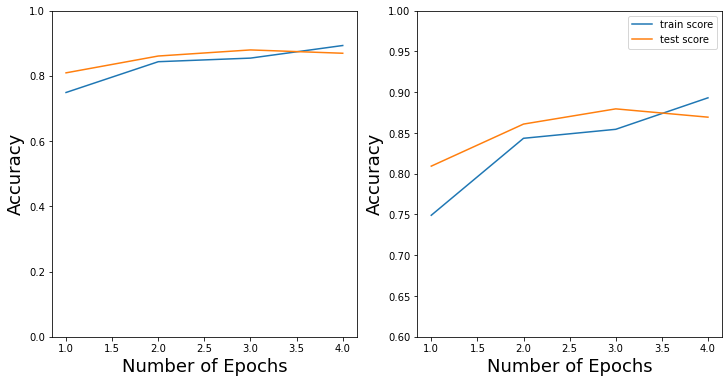

In [6]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, epochs+1), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, epochs+1), history.history['val_accuracy'], label='test score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, epochs+1), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, epochs+1), history.history['val_accuracy'], label='test score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
axarr[1].set_ylim([0.6,1])
plt.legend()
plt.show()